In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

from encoder import *
from AttnDecoder import * 
from seq2seq import *

from build_dataset import *
from inference import *
from tqdm import tqdm

from beamsearch import *

/ext3/conda/1011_project/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Load dataloaders 

In [2]:
# set whether or not model is pretrained
model_pretrained = True

In [3]:
# load data 
main_data_path = "data/processed"

train_file_path = {
    'source': f"{main_data_path}/src-train.txt",
    'target': f"{main_data_path}/tgt-train.txt"
}

test_file_path = {
    'source': f"{main_data_path}/src-test.txt",
    'target': f"{main_data_path}/tgt-test.txt"
}

dev_file_path = {
    'source': f"{main_data_path}/src-dev.txt",
    'target': f"{main_data_path}/tgt-dev.txt"
}

# build vocab with train data only 
vocab = build_train_vocab(train_file_path)

# build datasets for all train, test, dev
datasets = {
    'train': QAPair(train_file_path, vocab),
    'test': QAPair(test_file_path, vocab),
    'dev': QAPair(dev_file_path, vocab),
}

# build dataloaders
batch_size = 64
dataloaders = {}
for split, dataset in datasets.items():
    dataloaders[split] = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=partial(pad_collate_fn, pad_token=dataset.pad_idx)
    )

# 2. Load parsed GloVe embeddings

In [4]:
embed_size = 300
pretrained_vectors = {
    'enc': torch.load(f'embeddings/encoder_emb_{embed_size}.pt').float(),
    'dec': torch.load(f'embeddings/decoder_emb_{embed_size}.pt').float()
}

# input_size = len(train_dataset.answer_vocab) 
output_size = len(vocab['target'])

# 3. Train loop

## 3.1 Define train and eval steps

In [5]:
def train_step(batch, model, optimizer, criterion, device):
    input = batch.source_vecs.to(device) 
    inputs_len = batch.source_lens.to(device)
    target = batch.target_vecs.to(device)
    target_len = batch.target_lens.to(device) 
    
    model.train()

    dec_log_probs, dec_hidden, attn_scores_mat = model(input, target, inputs_len, target_len)

    # scores = s2s_output.view(-1, s2s_output.size(-1))
    
    optimizer.zero_grad()
    loss = criterion(dec_log_probs.transpose(1, 2), target)
    loss.backward()
    # clip gradients
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0, norm_type=2)
    
    optimizer.step()

    # return the attention scores at the last time step
    return loss.item(), dec_log_probs, attn_scores_mat

def eval_step(batch, model, criterion, device):
    input = batch.source_vecs.to(device) 
    inputs_len = batch.source_lens.to(device)
    target = batch.target_vecs.to(device)
    target_len = batch.target_lens.to(device) 
    
    model.eval()

    dec_log_probs, dec_hidden, attn_scores_mat = model(input, target, inputs_len, target_len)

    # scores = s2s_output.view(-1, s2s_output.size(-1))
    
    loss = criterion(dec_log_probs.transpose(1, 2), target)

    # return the attention scores at the last time step
    return loss.item(), dec_log_probs, attn_scores_mat
    

## 3.2 Run train loop

In [6]:
# TRAIN LOOP 

if not model_pretrained:
    # initial learning rate
    lr = 1.0
    # initialize the model, optimizer, and criterion
    seq2seq = Seq2Seq(pretrained_vectors, hidden_size=600, output_size=output_size)
    optimizer = torch.optim.SGD(seq2seq.parameters(), lr=lr)
    criterion = nn.NLLLoss(ignore_index=datasets['train'].pad_idx)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    seq2seq.to(device)

    plot_cache = {}
    plot_cache['train'] = []
    plot_cache['test'] = []

    # halve lr at epoch 8
    scheduler = StepLR(optimizer, step_size=8, gamma=0.5) 

    NUM_EPOCHS = 15
    for epoch in tqdm(range(NUM_EPOCHS)):    
        # train 
        train_losses = []
        for i, data in tqdm(enumerate(dataloaders['train']), leave=False):
            curr_loss, dec_log_probs, attn_scores_mat = train_step(data, seq2seq, optimizer, criterion, device)

            train_losses.append(curr_loss)

        avg_train_loss = np.mean(train_losses)
        print(f'Train loss after epoch {epoch+1} = {avg_train_loss}')

        # eval 
        test_losses = []
        with torch.no_grad():
            for i, data in tqdm(enumerate(dataloaders['test']), leave=False):
                curr_loss, dec_log_probs, attn_scores_mat = eval_step(data, seq2seq, criterion, device)

                test_losses.append(curr_loss)

            avg_test_loss = np.mean(test_losses)
            print(f'Test loss after epoch {epoch+1} = {avg_test_loss}')

        plot_cache['train'].append(avg_train_loss)
        plot_cache['test'].append(avg_test_loss)

        scheduler.step()

    # save the model state
    torch.save({'state_dict': seq2seq.state_dict(), 'plot_cache': plot_cache}, 'trained_seq2seq_statedict.pt')
else:
    # reload the model
    seq2seq = Seq2Seq(pretrained_vectors, hidden_size=600, output_size=output_size)
    criterion = nn.NLLLoss(ignore_index=datasets['train'].pad_idx)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    seq2seq.to(device)

    checkpoint = torch.load('trained_seq2seq_statedict.pt')
    seq2seq.load_state_dict(checkpoint['state_dict'])
    plot_cache = checkpoint['plot_cache']

In [7]:
# run inference on the test set
test_losses = []
all_best_attn_labels = []
all_preds_list = []
all_labels_list = []
raw_labels_list = []
all_cleaned_preds_list = []
all_bleu_1 = []
all_bleu_2 = []
all_bleu_3 = []
all_bleu_4 = []
all_meteor = []
all_rouge_l = []
with torch.no_grad():
    for i, data in tqdm(enumerate(dataloaders['test']), leave=False):
        # run beam search inference on the test set
        beam_search_batch(data, seq2seq, vocab['target'], device, beam_width=1)
        
        # create a matrix of the best attention score SRC token class 
        # best_attn_labels = unk_postprocessing(data.source_vecs, attn_scores_mat)
        # all_best_attn_labels.append(best_attn_labels)

        # evaluate the predictions with the metrics
        # bleu_1, bleu_2, bleu_3, bleu_4 = eval_metrics(preds_list, labels_list) # meteor, rouge_l
        # all_bleu_1.append(bleu_1)
        # all_bleu_2.append(bleu_2)
        # all_bleu_3.append(bleu_3)
        # all_bleu_4.append(bleu_4)
        # all_meteor.append(meteor)
        # all_rouge_l.append(rouge_l)

        # replace all unk tokens with the SRC token with the highest attention
        # cleaned_preds_list = []
        # for sen_idx in range(len(preds_list)):
        #     sentence = []
        #     for tok_idx, token in enumerate(preds_list[sen_idx]):
        #         if token == '<unk>':
        #             src_id = int(best_attn_labels[sen_idx][tok_idx].item())
        #             src_token = vocab['source'].decode_idx2token([src_id])
        #             sentence.append(src_token[0])
        #         else:
        #             sentence.append(preds_list[sen_idx][tok_idx])
        #     cleaned_preds_list.append(sentence)

        # all_preds_list.append(preds_list)
        # all_labels_list.append(labels_list)
        # all_cleaned_preds_list.append(cleaned_preds_list)
        # raw_labels_list.append(data.target_data)
        break


0it [00:00, ?it/s]

target question: ['how', 'many', 'people', 'were', 'left', 'homeless', 'because', 'of', 'the', 'earthquake', '?']
len candidates 3
after updating frontier
Prefix [1, 2134]
Sum log prob -14.964481353759766
Decoder output tensor([[2134]], device='cuda:0')
Decoder hidden tensor([[[ 0.0332, -0.2879, -0.0891,  ...,  0.1773, -0.3392, -0.0314]],

        [[-0.6489,  0.1066, -0.7120,  ...,  0.6436, -0.6028,  0.4995]]],
       device='cuda:0')
prefix ['<bos>', 'glaciers']
Prefix [1, 6207]
Sum log prob -14.166219711303711
Decoder output tensor([[6207]], device='cuda:0')
Decoder hidden tensor([[[ 0.0332, -0.2879, -0.0891,  ...,  0.1773, -0.3392, -0.0314]],

        [[-0.6489,  0.1066, -0.7120,  ...,  0.6436, -0.6028,  0.4995]]],
       device='cuda:0')
prefix ['<bos>', 'reefs']
Prefix [1, 6215]
Sum log prob -13.877104759216309
Decoder output tensor([[6215]], device='cuda:0')
Decoder hidden tensor([[[ 0.0332, -0.2879, -0.0891,  ...,  0.1773, -0.3392, -0.0314]],

        [[-0.6489,  0.1066, -0.7120

KeyboardInterrupt: 

In [33]:
# print out a few postprocesse predictions
for i in range(5):
    print('Target (Question) Label:', " ".join(raw_labels_list[0][i]))
    print('Target (Question) Raw Prediction:', " ".join(all_preds_list[0][i]))
    print('Target (Question) Postprocessed Prediction:', " ".join(all_cleaned_preds_list[0][i]))
    print('')

Target (Question) Label: what kind of classes are not offered in mittelschule ?
Target (Question) Raw Prediction: what kind of classes are not offered in <unk> ?
Target (Question) Postprocessed Prediction: what kind of classes are not offered in . ?

Target (Question) Label: whats the first year that beyonce appear on the time 100 list ?
Target (Question) Raw Prediction: whats the first year that <unk> appear on the time 100 list ?
Target (Question) Postprocessed Prediction: whats the first year that . appear on the time 100 list ?

Target (Question) Label: what are typical thermal mass material ?
Target (Question) Raw Prediction: what are typical thermal mass material ?
Target (Question) Postprocessed Prediction: what are typical thermal mass material ?

Target (Question) Label: what is the annual precipitation ?
Target (Question) Raw Prediction: what is the annual precipitation ?
Target (Question) Postprocessed Prediction: what is the annual precipitation ?

Target (Question) Label: 

In [17]:
# PLOT TRAIN AND VAL LOSS
import matplotlib.pyplot as plt 
def plot_over_training(per_epoch_metrics, title_name, num_epochs):
    t = np.arange(1, num_epochs+1)

    fig, ax1 = plt.subplots()

    colors = ['tab:blue', 'tab:red']
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')

    for key, color in zip(per_epoch_metrics, colors):
        label = f'{key}_loss'
        ax1.plot(t, per_epoch_metrics[key], color=color, linewidth=1, label=label)

    ax1.tick_params(axis='y')
    ax1.legend(loc='upper right')

    fig.tight_layout
    plt.title(title_name)
    plt.show()


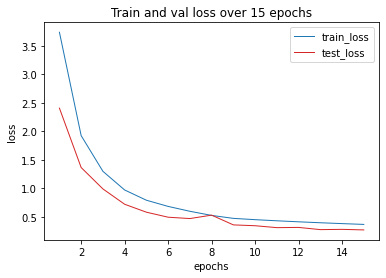

In [20]:
plot_over_training(plot_cache, 'Train and val loss over 15 epochs', 15)